<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/3.%20Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3a. Baseline Model – TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;">TF-IDF vectorization + logistic regression as a benchmark.</p>
</div>


## Baseline Sentiment Classifier: TF-IDF + Logistic Regression

This notebook implements the **baseline model** for our tweet sentiment classification project, using a combination of **TF-IDF vectorization** and **Logistic Regression**.

### Why TF-IDF + Logistic Regression?

- **TF-IDF** transforms raw tweet text into numerical feature vectors by measuring the importance of words relative to the entire corpus.
- **Logistic Regression** is a simple yet effective linear classifier that provides strong performance with fast training time and easy interpretability.

TF-IDF is ideal for linear models but sensitive to document length. To prevent longer tweets from biasing the model, we apply **L2 normalization**, ensuring each tweet contributes equally regardless of length.

### What This Notebook Covers

- Loads preprocessed training and validation data
- Tokenizes and normalizes text using TF-IDF
- Tunes hyperparameters using `GridSearchCV`
- Trains a logistic regression model on vectorized tweets
- Evaluates performance on the validation set using accuracy, precision, recall, F1 score, and a confusion matrix
- Saves the trained pipeline for reuse in evaluation

This baseline serves as a reference point for evaluating deeper models like LSTM and BERT, helping us assess whether the added complexity improves sentiment classification.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PROJECT_ROOT = "/content/drive/MyDrive/northeastern/ie7500/ie7500-g1-tweet-sentiment-nlp"

In [3]:
train_path = f"{PROJECT_ROOT}/processed_data/train_dataset.csv"
val_path = f"{PROJECT_ROOT}/processed_data/val_dataset.csv"

In [4]:
import sys
!{sys.executable} -m pip install -r "{PROJECT_ROOT}/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.7 MB/s eta 0:00:00


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [6]:
# Import helper functions
sys.path.append(f"{PROJECT_ROOT}/utils")
from helper import load_clean_train_val_datasets

In [7]:
train_df, val_df = load_clean_train_val_datasets(train_path, val_path)

In [8]:
train_df.head()

,text,target
0,doesnt know hahahahahaha hi world twitter,4
1,gahh im hungryy shouldve something teadinner s...,0
2,last day,0
3,sunburn forget put sunblock shnatzi,0
4,usermention want go home contact hurt,0


In [9]:
val_df.head()

,text,target
0,lng fn day mah head killin im tire den bih bt ...,0
1,usermention nah manthat fit lmao run mix oh ma...,4
2,usermention kno right thermostat war almost al...,0
3,usermention awww well dont worry youre miss mu...,0
4,use little girls room soo bad soon leave bos c...,0


#### Observation: Dataset Inspection and Language Quality

After loading the dataset, we inspect the first few rows using `head()`. The `text` column contains raw tweets, which often include:

* Informal language and slang (e.g., "lmao", "bt", "nah manthat")
* Typos, abbreviations, and creative spellings
* Phonetic spellings or dialect-specific phrasing
* Hashtags, emojis, or special characters
* Occasionally, non-English or mixed-language content

This is **expected behavior** for the Sentiment140 dataset, which was collected from Twitter and reflects real-world, noisy text data.

While most tweets are in English or English-based internet slang, it's possible that some non-English tweets are present. For now, we retain this noise to maintain the dataset's realism, which helps models generalize to real-world social media inputs.

In [10]:
# next, we extract targets

# Ensure 'target' is int and remap 4 → 1
X_train = train_df['text'].astype(str)
y_train = train_df['target'].astype(int).replace({4: 1})

X_val = val_df['text'].astype(str)
y_val = val_df['target'].astype(int).replace({4: 1})


# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)

Train shape: (1119609, 2)
Validation shape: (239917, 2)
X_train shape: (1119609,) | y_train shape: (1119609,)
X_val shape: (239917,) | y_val shape: (239917,)


### Why Use TF-IDF Instead of Word Embeddings?

Here, we use **TF-IDF vectorization** in combination with **Logistic Regression** to build a baseline sentiment classifier. A natural question is: _Why not use word embeddings like Word2Vec, GloVe, or BERT instead of TF-IDF?_ Here's why:

#### TF-IDF is Simple and Effective for Linear Models
TF-IDF (Term Frequency–Inverse Document Frequency) transforms text into sparse vectors that indicate the relative importance of each word in the tweet. This is ideal for traditional linear models like Logistic Regression, which rely on **high-dimensional but interpretable** feature inputs.

#### Embeddings Require Context-Aware Models
Word embeddings (like Word2Vec or BERT) encode semantic similarity — which is powerful — but they are designed to be used with **neural network models** like LSTMs or Transformers. These models can learn complex patterns in dense embeddings, while Logistic Regression cannot exploit such structure effectively.

#### Interpretable and Lightweight
TF-IDF allows us to inspect which words are influential for predictions by analyzing model coefficients. This interpretability is important in early stages and baselines. Additionally, it's **faster to compute** and doesn't rely on external pretrained models.

### Logistic Regression with TF-IDF: Why Normalization is Essential

In this notebook, we use `TfidfVectorizer` to transform tweets into numerical vectors before training a Logistic Regression classifier for sentiment prediction.

However, tweets can vary widely in length — some are just a few words, while others are long sentences. If we don't normalize the TF-IDF vectors, longer tweets may end up with higher total values simply because they contain more words. This can unintentionally bias the classifier to favor longer inputs.

To address this, we apply **L2 normalization** to all TF-IDF vectors. This ensures that every tweet, regardless of length, contributes equally to the model — and the prediction depends more on the **pattern of word importance** rather than the **number of words**.

By default, `TfidfVectorizer(norm='l2')` handles this for us, making our input vectors have unit length and preventing length-based skew in model training.

### What Does `ngram_range=(1, 2)` Mean?

This setting in `TfidfVectorizer` tells the model to include:

- **Unigrams**: Individual words (e.g., `"great"`, `"movie"`)
- **Bigrams**: Pairs of consecutive words (e.g., `"not good"`, `"very happy"`)

Including bigrams allows the model to better capture **local context** and **phrases with meaning** that might be lost with unigrams alone.

**Why it's important for tweets**:
Tweets are short and often use expressions like:
- `"not bad"` (which is positive, but individual words could mislead)
- `"love it"`, `"hate this"` — strong sentiment phrases

By using both unigrams and bigrams, the model can learn richer patterns of sentiment.


### What Does `max_features=10000` Mean?

This parameter limits the vocabulary to the **top 10,000 most frequent or informative terms** after preprocessing.

**Why it matters**:
- Prevents the model from being overwhelmed by **rare or noisy words**
- Reduces **memory usage** and **training time**
- Helps avoid **overfitting**, especially on short and noisy data like tweets

**Tradeoff**:
- Too few features → risk missing important terms
- Too many features → slower training and possible overfitting

`10000` is a reasonable default, but this value can be tuned based on dataset size and performance.


In [11]:
# Then, we define pipeline combining TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        norm='l2'
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])

### Hyperparameter Tuning

Here, we apply **GridSearchCV** to optimize the hyperparameters of our TF-IDF + Logistic Regression pipeline.

#### What is GridSearchCV?

`GridSearchCV` is a tool in scikit-learn that automates hyperparameter tuning. Instead of manually guessing the best values for model settings (like regularization strength or n-gram range), GridSearchCV systematically tries out all combinations of parameters in a defined grid and evaluates them using cross-validation.

#### Why It Matters:

Different parameter settings can dramatically affect model performance. For example:
- A **high regularization (C)** might underfit the data
- A **broad n-gram range** might capture more context, or lead to overfitting
- Filtering out common/rare words using **`max_df`** and **`min_df`** can improve generalization

By evaluating each configuration using **3-fold cross-validation**, we get a reliable estimate of how each setting performs across the data.

#### What We Tuned:
- **TF-IDF vectorizer**:
  - `max_features`, `ngram_range`, `min_df`, `max_df`
- **Logistic Regression**:
  - `C` (regularization), `penalty`, `class_weight`

The best combination is selected based on **weighted F1 score**, which balances precision and recall in the presence of class imbalance.

In [12]:
# Then, we define parameter grid for GridSearch
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
    'tfidf__max_df': [0.7, 0.9],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],  # 'l1' requires solver='liblinear'
    'clf__class_weight': [None, 'balanced']
}

# Setup GridSearchCV with 3-fold CV and weighted F1
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

# Perform grid search
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Extract best model from grid search
best_model = grid_search.best_estimator_

# Show best parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)


Starting hyperparameter tuning...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best Parameters Found:
{'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [14]:
# Then, we train our Logistic Regression Model

TFIDF_LogReg_model = best_model

TFIDF_LogReg_model.fit(X_train, y_train)

# Save the trained pipeline (TF-IDF + Logistic Regression)
joblib.dump(TFIDF_LogReg_model, f"{PROJECT_ROOT}/models/tfidf_logreg_pipeline.joblib")
print("Model saved to tfidf_logreg_pipeline.joblib")

Model saved to tfidf_logreg_pipeline.joblib


In [15]:
# Then we evaluate the Model

# Predict on validation set
y_val_pred = TFIDF_LogReg_model.predict(X_val)

# Compute metrics
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, zero_division=0)
rec = recall_score(y_val, y_val_pred, zero_division=0)
f1 = f1_score(y_val, y_val_pred, zero_division=0)

# Print summary
print("\n--- Validation Performance (Logistic Regression) ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


--- Validation Performance (Logistic Regression) ---
Accuracy:  0.7816
Precision: 0.7700
Recall:    0.8032
F1 Score:  0.7862


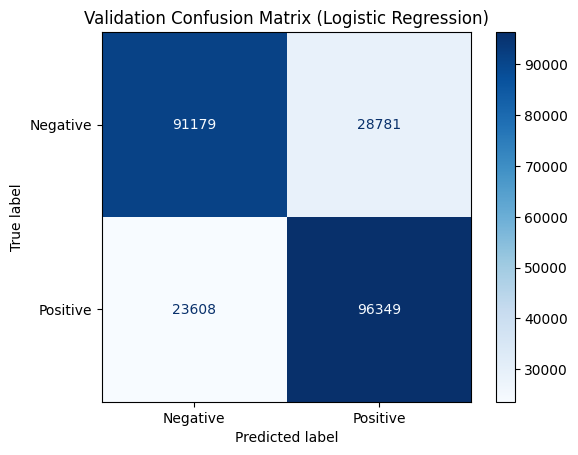

In [16]:
# Next, we view the confusion matrix

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
plt.title("Validation Confusion Matrix (Logistic Regression)")
plt.grid(False)
plt.show()